In [ ]:
# pip install plotly

In [18]:
# 1) 라이브러리 임포트 및 기본 설정
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers, callbacks

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


In [58]:
# 1) pandas로 CSV 읽을 때 인코딩 및 압축 옵션 지정
import pandas as pd

file_path = './onchain/usdt_onchain.csv'  # 실제 경로에 맞춰 수정

# 우선 gzip 압축 여부를 확인하여 압축 해제 옵션 적용
try:
    df = pd.read_csv(file_path, compression='gzip', encoding='utf-8')
except (OSError, UnicodeDecodeError):
    # gzip 압축이 아니거나 utf-8 디코딩 실패 시, latin1로 재시도
    df = pd.read_csv(file_path, encoding='latin1')
    
    if 'Date' not in df.columns:
    # 기준 날짜 설정 (Age 문자열이 기준일로부터 계산된 값이므로)
        reference_date = datetime(2025, 5, 31)

    # 'Age' 문자열을 datetime으로 변환하는 함수 정의
    def age_to_datetime(age_str):
        try:
            parts = age_str.split()
            number = int(parts[0])
            unit = parts[1]
            if 'day' in unit:
                return reference_date - timedelta(days=number)
            elif 'hour' in unit:
                return reference_date - timedelta(hours=number)
            elif 'minute' in unit:
                return reference_date - timedelta(minutes=number)
            else:
                return pd.NaT
        except:
            return pd.NaT

    # 'Age'를 기반으로 'Date' 컬럼 생성
    df['Date'] = df['From'].apply(age_to_datetime)

    # 'Date' 컬럼을 기준으로 Unix 타임스탬프(초 단위) 추가
    df['Timestamp'] = df['Date'].apply(lambda x: int(x.timestamp()) if pd.notna(x) else None)

    # CSV에 덮어쓰기
    df.to_csv(file_path, index=False, encoding='utf-8-sig')

    print("Date와 Timestamp가 추가되어 CSV가 덮어쓰여졌습니다.")

# 컬럼명 앞뒤 공백 제거
df.columns = df.columns.str.strip()

# 2) ValueUSD 컬럼 전처리: 문자열로 변환 후 $, 쉼표 제거 → 숫자 타입 변환
df['ValueUSD'] = df['Value (USD)'].astype(str).str.replace(r'[\$,]', '', regex=True)
df['ValueUSD'] = pd.to_numeric(df['ValueUSD'], errors='coerce')

# Date 컬럼을 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 분석에 필요한 컬럼만 추출
df = df[['Date', 'Amount', 'ValueUSD']].dropna()

# 3) 일별 집계 생성
daily_agg = df.groupby('Date').agg(
    daily_count=('ValueUSD', 'count'),
    daily_sum=('ValueUSD', 'sum')
).reset_index()

Date와 Timestamp가 추가되어 CSV가 덮어쓰여졌습니다.


                                Date      ValueUSD
count                          46375  4.637500e+04
mean   2023-03-11 13:53:45.367115776  4.197627e+07
min              2020-01-03 00:00:00  1.600000e+07
25%              2021-10-28 00:00:00  2.000000e+07
50%              2023-03-16 00:00:00  2.685388e+07
75%              2024-09-02 00:00:00  4.626160e+07
max              2025-04-30 00:00:00  9.999999e+08
std                              NaN  5.165610e+07


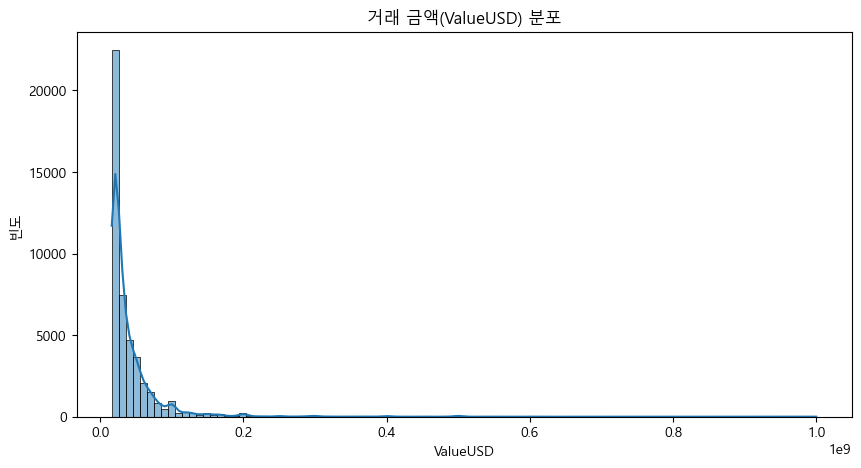

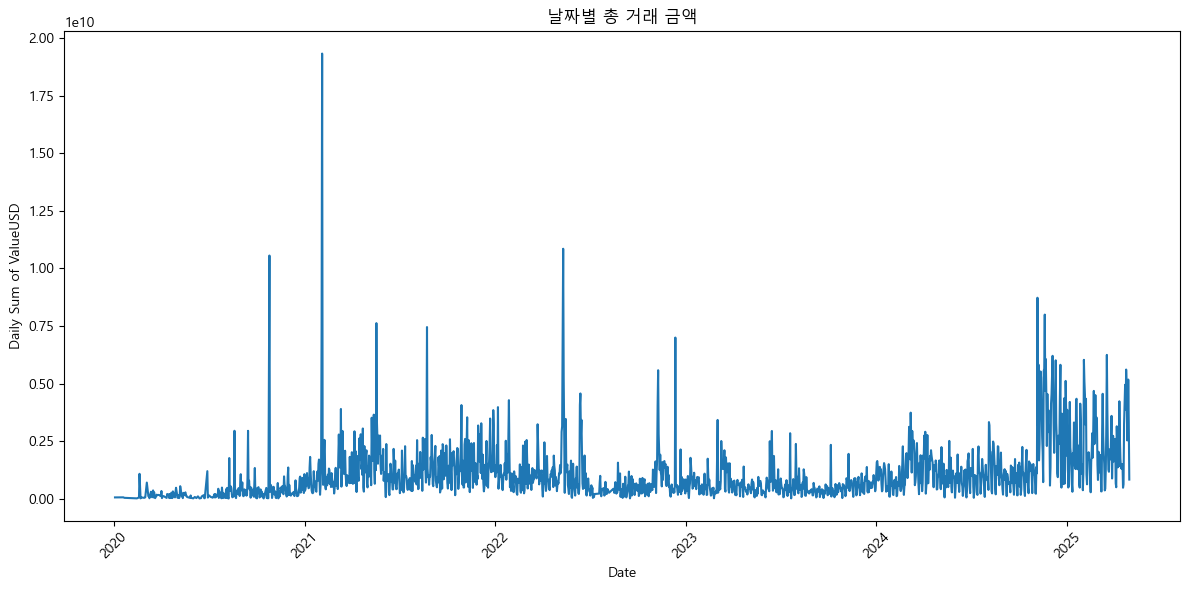

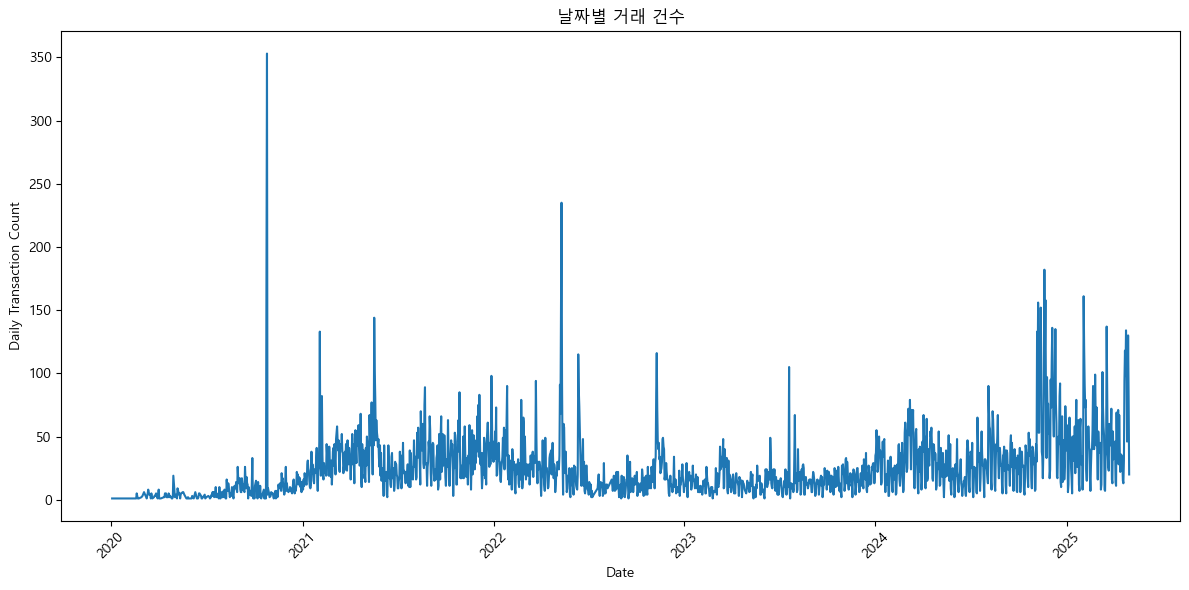

In [59]:
# 3) 탐색적 데이터 분석(EDA): 기초 통계 및 시각화

# 3-1) 기초 통계 출력
print(df.describe())

# 3-2) 거래 금액(ValueUSD) 분포 히스토그램 (seaborn 사용)
plt.figure(figsize=(10, 5))
sns.histplot(df['ValueUSD'].dropna(), bins=100, kde=True)
plt.title('거래 금액(ValueUSD) 분포')
plt.xlabel('ValueUSD')
plt.ylabel('빈도')
plt.show()

# 3-4) 날짜별 총 거래 금액 시각화 (seaborn 사용)
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_agg, x='Date', y='daily_sum')
plt.title('날짜별 총 거래 금액')
plt.xlabel('Date')
plt.ylabel('Daily Sum of ValueUSD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3-5) 날짜별 거래 건수 시각화 (seaborn 사용)
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_agg, x='Date', y='daily_count')
plt.title('날짜별 거래 건수')
plt.xlabel('Date')
plt.ylabel('Daily Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
# 4) CNN 모델 학습을 위한 시계열 데이터셋 생성 (1D CNN)

# 4-1) daily_sum을 예측 대상으로 설정
series = daily_agg[['Date', 'daily_sum']].copy()
series.set_index('Date', inplace=True)

# 4-2) Min-Max 스케일링
scaler = MinMaxScaler()
series['scaled_sum'] = scaler.fit_transform(series[['daily_sum']])

# 4-3) 시퀀스 생성 함수 정의 (과거 30일 데이터를 사용해 다음날 예측)
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

values = series['scaled_sum'].values
window_size = 30
X_all, y_all = create_sequences(values, window_size)

# 4-4) 학습/검증 데이터 분리 (8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=False
)

# 4-5) CNN 입력 형태 맞추기 (samples, time_steps, features)
X_train = X_train.reshape((-1, window_size, 1))
X_val   = X_val.reshape((-1, window_size, 1))


In [64]:
# 5) 1D CNN 모델 정의 및 컴파일

model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,937 (175.54 KB)

 Trainable params: 44,937 (175.54 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# 6) 모델 학습 (EarlyStopping 콜백 사용)
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1
)


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0025 - mae: 0.0295 - val_loss: 0.0050 - val_mae: 0.0466
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0278 - val_loss: 0.0044 - val_mae: 0.0479
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0255 - val_loss: 0.0042 - val_mae: 0.0491
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0250 - val_loss: 0.0041 - val_mae: 0.0442
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mae: 0.0292 - val_loss: 0.0041 - val_mae: 0.0440
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0259 - val_loss: 0.0048 - val_mae: 0.0434
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0240 - val_loss: 0.0041 - val_mae: 0.0409
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0049 - val_mae: 0.0440
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.002

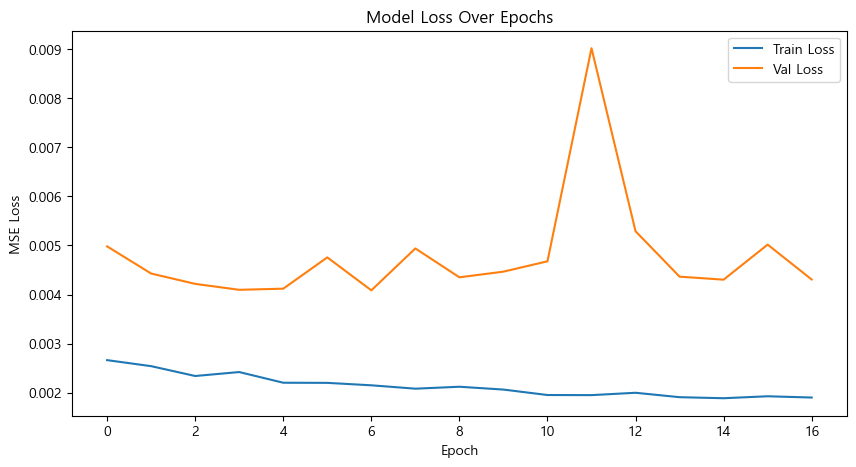

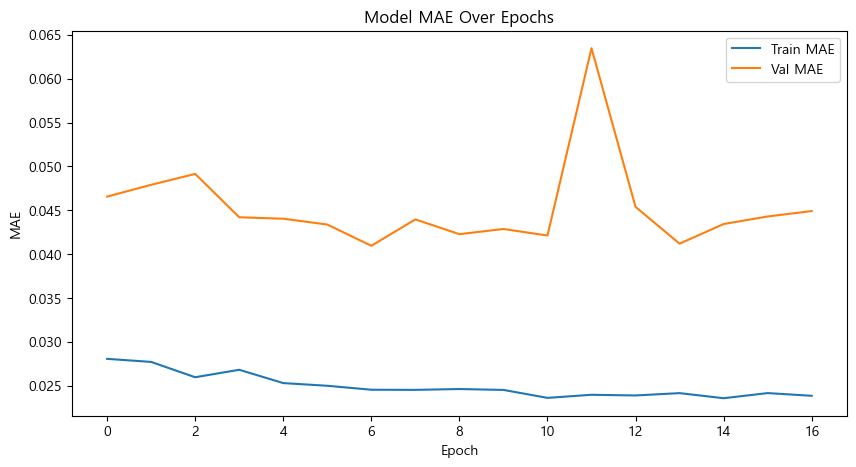

In [68]:
# 7) 학습 결과 시각화: 손실 및 MAE 변화

# 7-1) 손실(Loss) 변화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 7-2) MAE 변화
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


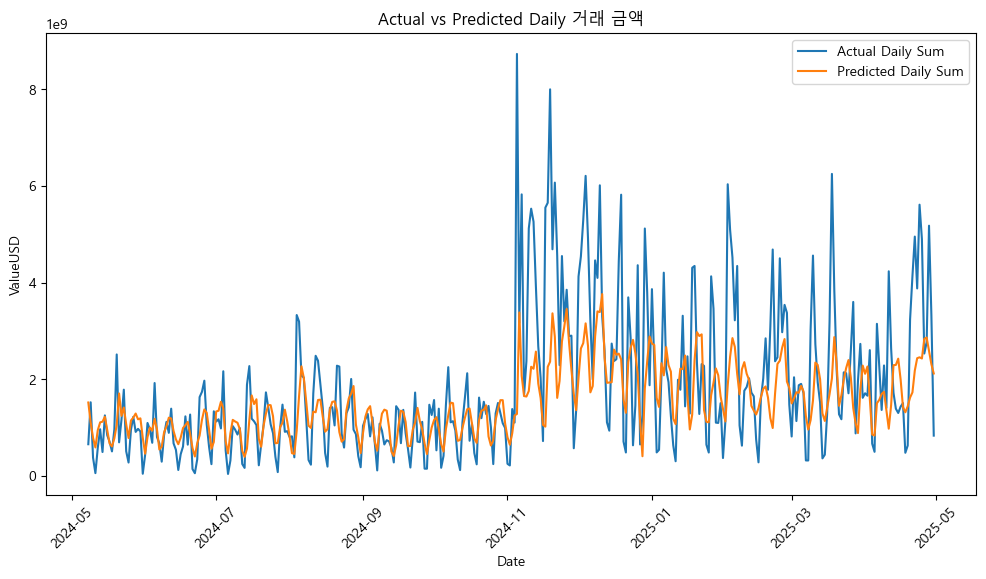

In [69]:
# 8) 모델 평가 및 예측 결과 복원

# 8-1) 검증 세트에 대한 예측
y_pred_scaled = model.predict(X_val)

# 8-2) 스케일 복원
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred_scaled).flatten()

# 8-3) 예측 vs 실제 시각화
val_dates = series.index[window_size + len(y_train):window_size + len(y_train) + len(y_val)]

plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_val_actual, label='Actual Daily Sum')
plt.plot(val_dates, y_pred_actual, label='Predicted Daily Sum')
plt.title('Actual vs Predicted Daily 거래 금액')
plt.xlabel('Date')
plt.ylabel('ValueUSD')
plt.xticks(rotation=45)
plt.legend()
plt.show()


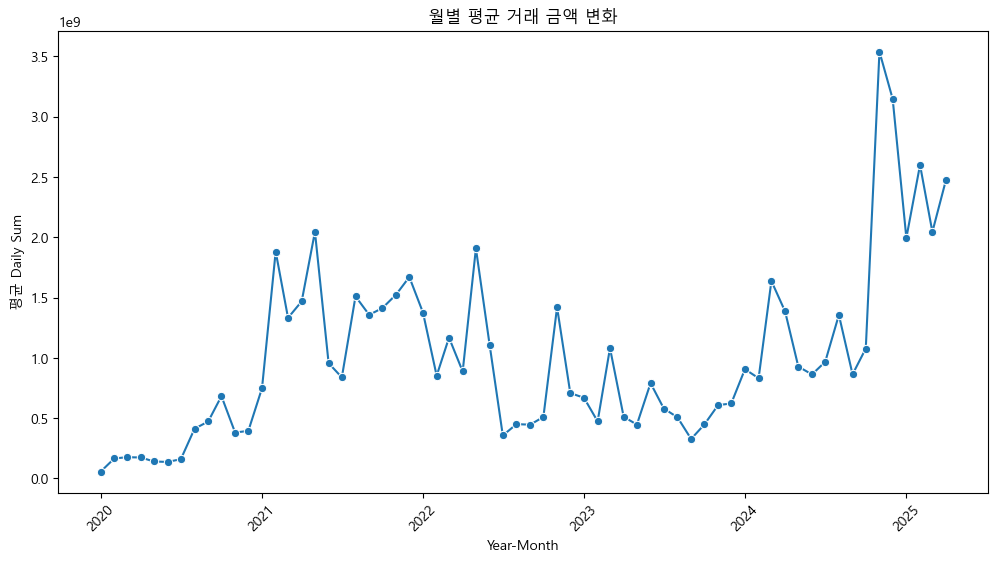

In [70]:
# 10) 필요 시 추가 시각화 예시: 월별 평균 거래 금액 변화

# 10-1) 월별로 집계
series_month = daily_agg.copy()
series_month['YearMonth'] = series_month['Date'].dt.to_period('M')
monthly_avg = series_month.groupby('YearMonth')['daily_sum'].mean().reset_index()
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()

# 10-2) 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='YearMonth', y='daily_sum', marker='o')
plt.title('월별 평균 거래 금액 변화')
plt.xlabel('Year-Month')
plt.ylabel('평균 Daily Sum')
plt.xticks(rotation=45)
plt.show()
